In [1]:
path = "/home/sourav/cra"

Simulation study. Several iterations of data generated, CRA estimated, double robustness proof. 

In [2]:
import sys, os
sys.path.append(os.path.abspath("..")) 
from src.simulator import generate_data
from src.estimator import cra_estimator
from src.states import *

import os, sys
import numpy as np
import pandas as pd
from tqdm import trange
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
# simulation parameters
N_MC = 400          # Monte Carlo iterations
n = 1000             # individuals
T = 4               # time steps
p = 4               # state variables
k = 3               # actions

# feature subsets for misspecification
features_full = [f"Z{i+1}" for i in range(p)]
features_miss1 = ["Z1", "Z2"]   # drop some features for outcome misspecification
features_miss2 = ["Z3", "Z4"]   # drop some features for propensity misspecification

In [4]:
results = []
for seed in trange(N_MC, desc="Monte Carlo runs", leave=False):
    df = generate_data(n=n, T=T, p=p, k=k, seed=seed)
    theta_correct, _ = cra_estimator(df, features_full, k=k)
    theta_m_miss, _ = cra_estimator(df, features_miss1, k=k)
    theta_e_miss, _ = cra_estimator(df, features_miss2, k=k)
    theta_both_miss, _ = cra_estimator(df, ["Z1"], k=k)
    for a in range(k):
        results.extend([
            {"seed": seed, "action": a, "scenario": "correct", "estimate": theta_correct[a]},
            {"seed": seed, "action": a, "scenario": "m_miss", "estimate": theta_m_miss[a]},
            {"seed": seed, "action": a, "scenario": "e_miss", "estimate": theta_e_miss[a]},
            {"seed": seed, "action": a, "scenario": "both_miss", "estimate": theta_both_miss[a]}
        ])
print("Monte Carlo complete.");

Monte Carlo runs:   0%|          | 0/400 [00:00<?, ?it/s]/home/sourav/miniconda3/lib/python3.13/site-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
/home/sourav/miniconda3/lib/python3.13/site-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
/home/sourav/miniconda3/lib/python3.13/site-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
/home/sourav/miniconda3/lib/python3.13/site-packa

Monte Carlo complete.


In [5]:
df_results = pd.DataFrame(results)
df_results.head()
os.makedirs("../data", exist_ok=True)
save_path = "../data/simulation_results_cra.csv"
df_results.to_csv(save_path, index=False)
print(f"Monte Carlo results saved to {save_path}")

Monte Carlo results saved to ../data/simulation_results_cra.csv


In [6]:
#box plots
df_results = pd.read_csv("../data/simulation_results_cra.csv")

# compute the average CRA estimate when both models are correct
ref_means = (
    df_results.query("scenario == 'correct'")
    .groupby("action")["estimate"]
    .mean()
    .to_dict()
)
print("Reference (CRA-correct) means:", ref_means)

Reference (CRA-correct) means: {0: -0.012551898000009085, 1: -0.013256763908197005, 2: -0.012552404355309578}


In [7]:
scenarios_to_plot = ["m_miss", "e_miss", "both_miss"]
df_plot = df_results[df_results["scenario"].isin(scenarios_to_plot)]

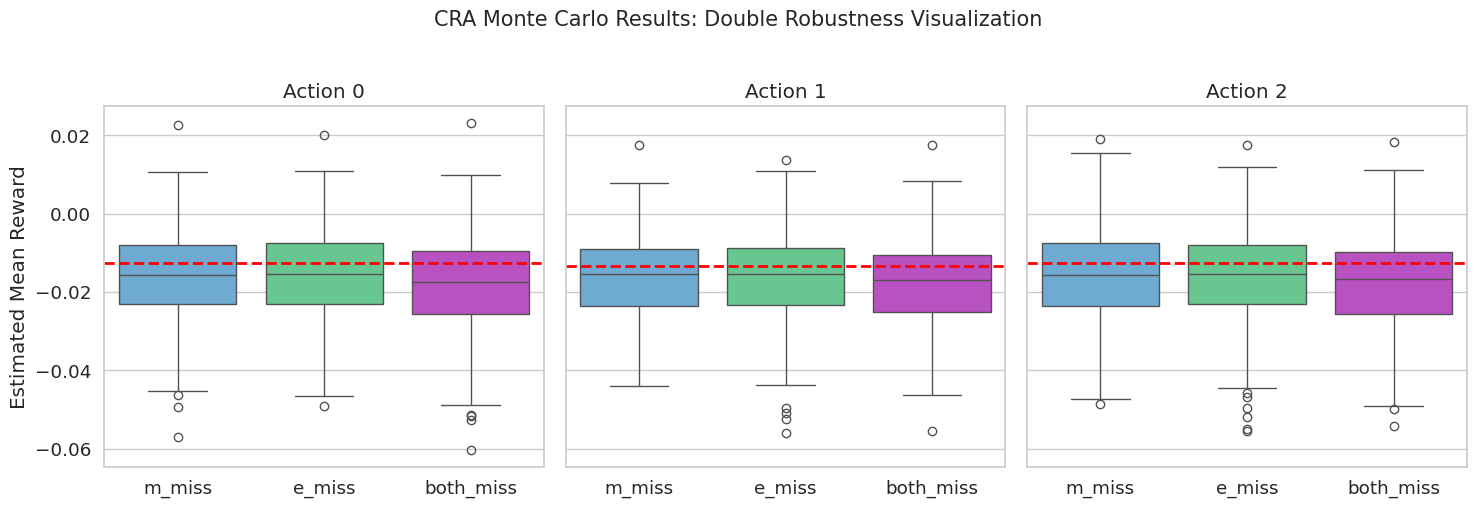

In [12]:
sns.set_theme(style="whitegrid", font_scale=1.2)
actions = sorted(df_plot["action"].unique())

fig, axes = plt.subplots(1, len(actions), figsize=(15, 5), sharey=True)

for idx, a in enumerate(actions):
    ax = axes[idx]
    subset = df_plot[df_plot["action"] == a]
    sns.boxplot(
    data=subset,
    x="scenario",
    y="estimate",
    hue="scenario",
    ax=ax,
    order=["m_miss", "e_miss", "both_miss"],
    palette=["#5DADE2", "#58D68D", "#C83ED492"],
    legend=False
)
    # add horizontal line for CRA-correct reference
    ax.axhline(y=ref_means[a], color="red", linestyle="--", linewidth=2)
    ax.set_title(f"Action {a}")
    ax.set_xlabel("")
    if idx == 0:
        ax.set_ylabel("Estimated Mean Reward")
    else:
        ax.set_ylabel("")

plt.suptitle("CRA Monte Carlo Results: Double Robustness Visualization", fontsize=15, y=1.02)
plt.tight_layout()
#fig.set_size_inches(18, 6)
plt.savefig(os.path.join(path, "plots/cra_results.png"), dpi=400, bbox_inches="tight")
plt.show()

In [16]:
summary = df_plot.groupby(["action","scenario"])["estimate"].agg(['mean','std'])
print(summary)

                      mean       std
action scenario                     
0      both_miss -0.013646  0.010550
       e_miss    -0.012181  0.010086
       m_miss    -0.012390  0.010433
1      both_miss -0.014277  0.010731
       e_miss    -0.013024  0.010796
       m_miss    -0.012813  0.010445
2      both_miss -0.013177  0.011025
       e_miss    -0.012496  0.011170
       m_miss    -0.012247  0.010978
